<a href="https://colab.research.google.com/github/Anagha235/CNN-Data-Science-Project/blob/main/BaslineCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

In [181]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop, RandomContrast,RandomTranslation
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from sklearn.svm import SVC
from keras.saving import register_keras_serializable
from tensorflow.keras import layers, Model, Input
import keras_tuner as kt
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.patches as patches
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import random

# Data Analysis

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
data_path = r'/content/drive/MyDrive/RealWaste 1'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32

)

Found 3734 files belonging to 8 classes.


In [88]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [89]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label


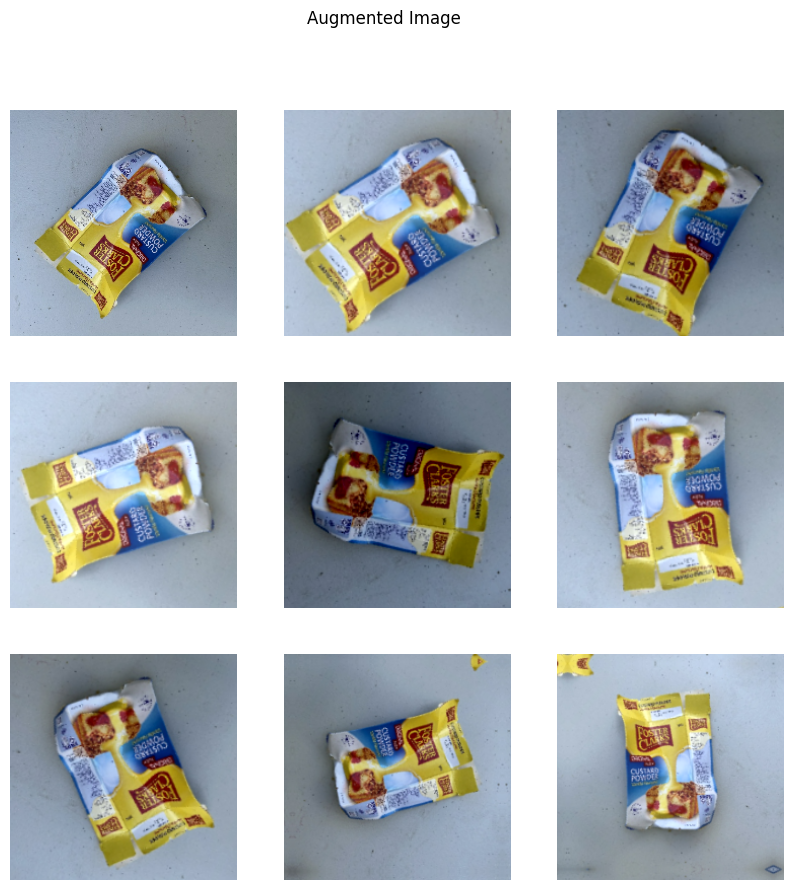

In [90]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle('Augmented Image')
    plt.show()


visualize_dataset(dataset, class_names)

In [91]:

def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [92]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [93]:
shuffled_dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)


train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

train_dataset = shuffled_dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)


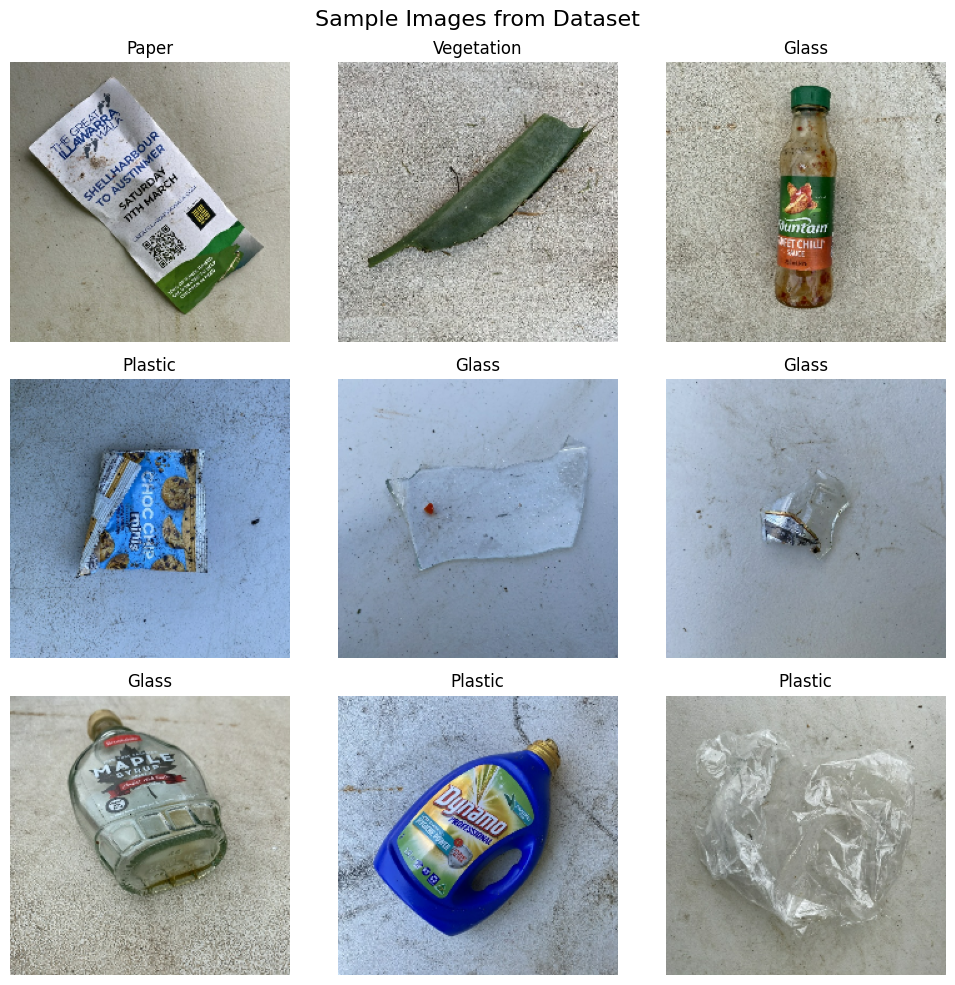

In [ ]:
plt.figure(figsize=(10, 10))


for images, labels in dataset.take(1):
  for i in range(9):
    image = images[i]
    label_idx = labels[i].numpy()

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()



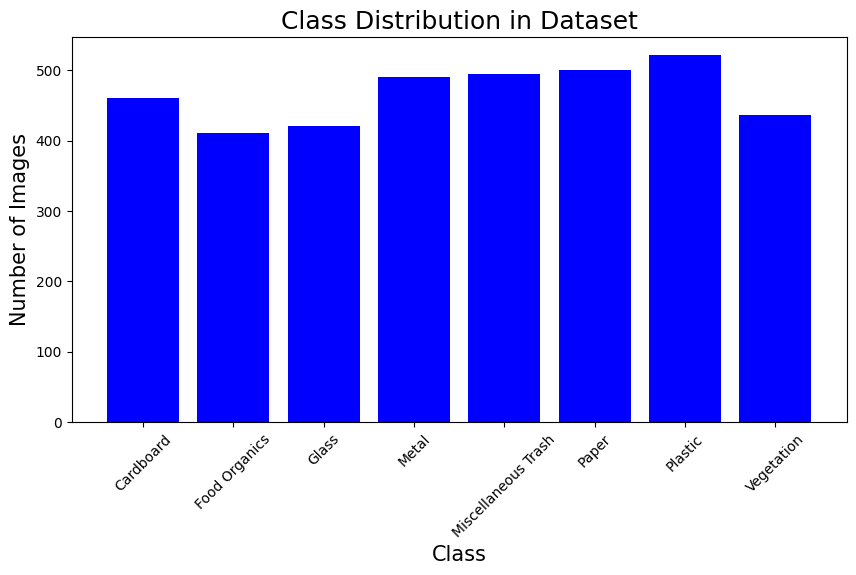

In [ ]:

class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

# Basline CNN


In [ ]:
def scheduler(epoch, lr):
    min_lr = 1e-5
    if epoch < 5:
        return lr
    else:
        new_lr = float(lr * tf.math.exp(-0.1))
        return max(new_lr, min_lr)
lr_scheduler = LearningRateScheduler(scheduler)



In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
input_layer = Input(shape=(224, 224, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.GlobalAveragePooling2D()(x)


x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

output_layer = layers.Dense(num_classes, activation='softmax')(x)


model = Model(inputs=input_layer, outputs=output_layer)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 491,592 (1.88 MB)

 Trainable params: 489,864 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset,  callbacks=[lr_scheduler, reduce_lr])

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 58s 493ms/step - accuracy: 0.2289 - loss: 2.8231 - val_accuracy: 0.1066 - val_loss: 2.6614 - learning_rate: 0.0010
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 439ms/step - accuracy: 0.3519 - loss: 2.3319 - val_accuracy: 0.1287 - val_loss: 3.3208 - learning_rate: 0.0010
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 438ms/step - accuracy: 0.4109 - loss: 2.1356 - val_accuracy: 0.1342 - val_loss: 3.7842 - learning_rate: 0.0010
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.4419 - loss: 2.0616
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 438ms/step - accuracy: 0.4419 - loss: 2.0613 - val_accuracy: 0.1232 - val_loss: 3.7062 - learning_rate: 0.0010
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 436ms/step - accuracy: 0.4716 - loss: 1.9184 - val_accuracy: 0.1728 - val_loss: 2.8141 - learning_rate: 5.0000e-04
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 438ms/step - accuracy: 0.4895 - loss: 

In [ ]:
model.save("/content/drive/MyDrive/my_model.keras")

In [ ]:
model = load_model(
    "/content/drive/MyDrive/my_model.keras",
)

In [ ]:
y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [ ]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.75      0.61      0.68        83
           1       0.57      0.46      0.50        57
           2       0.77      0.47      0.59        57
           3       0.84      0.69      0.76        74
           4       0.65      0.22      0.33        78
           5       0.42      0.89      0.57        72
           6       0.85      0.55      0.67        75
           7       0.45      1.00      0.62        48

    accuracy                           0.60       544
   macro avg       0.66      0.61      0.59       544
weighted avg       0.67      0.60      0.59       544



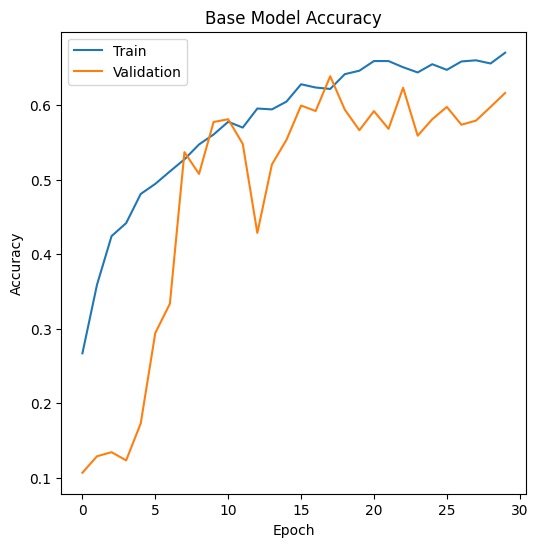

In [ ]:
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

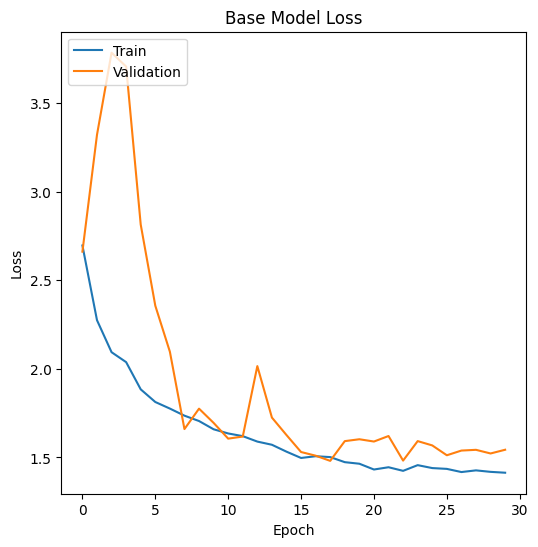

In [ ]:
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

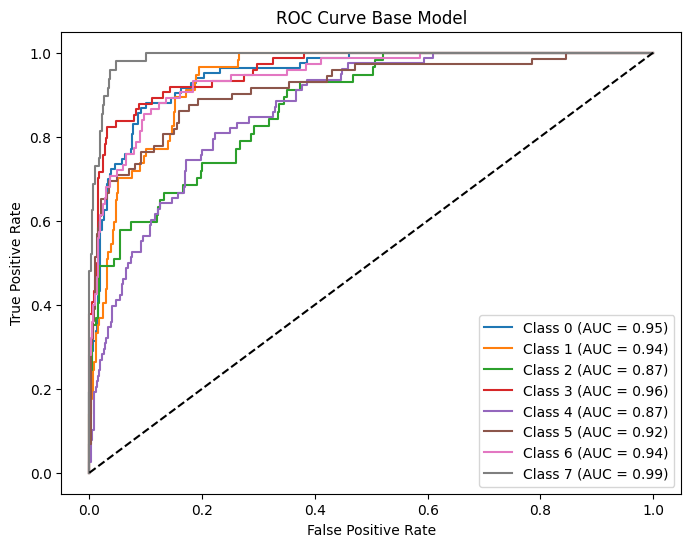

In [196]:

num_classes = 8
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Base Model")
plt.legend()
plt.show()

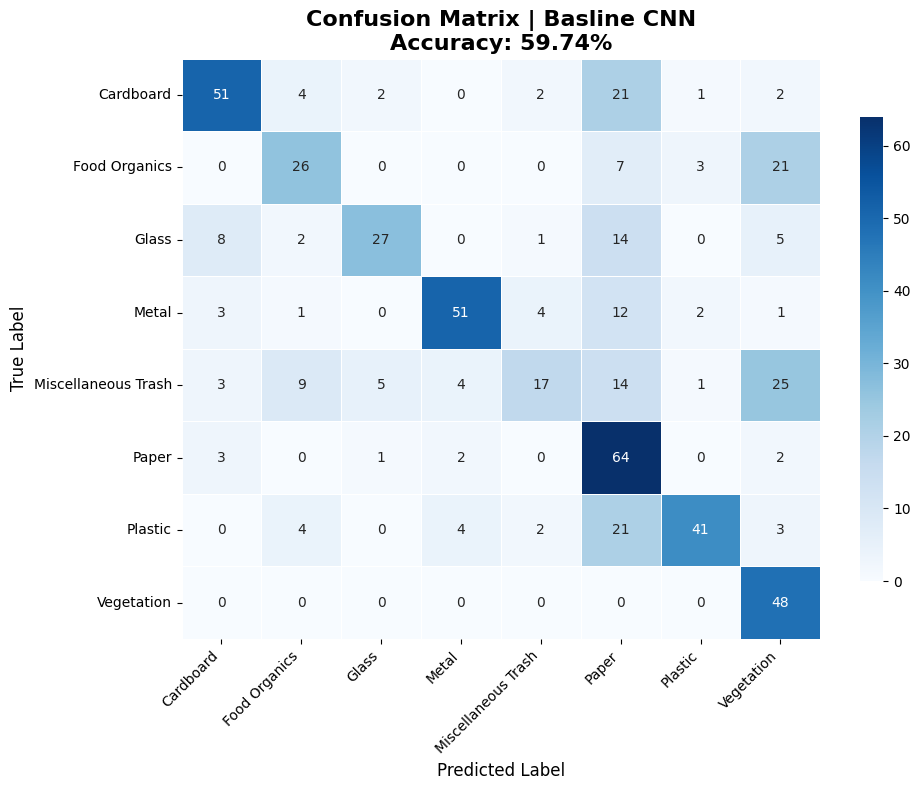

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Basline CNN"):
    cm = confusion_matrix(y_true_base, y_pred_base)
    acc = accuracy_score(y_true_base, y_pred_base) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_true_base, y_pred_base, class_names, model_name="Basline CNN")

In [ ]:

test_loss_base, test_acc_base = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6638 - loss: 1.4876
Test Accuracy: 0.6398
Test Loss: 1.5009


In [ ]:
def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        predictions = model.predict(images, verbose=0)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            prob_vector = predictions[i]
            pred_label = np.argmax(prob_vector)

            ax = plt.subplot(3, 3, i + 1)


            img = image.numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            ax.imshow(img)
            ax.axis("off")


            title_color = "green" if pred_label == true_label else "red"
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                fontsize=10,
                color=title_color
            )


            top3 = np.argsort(prob_vector)[-3:][::-1]
            prob_text = "\n".join([f"{class_names[j]}: {prob_vector[j]*100:.1f}%" for j in top3])
            ax.text(0.5, -0.25, prob_text, transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle("Baseline CNN Classification with Top 3 Probabilities", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


In [ ]:

model_base = load_model(
    "/content/drive/MyDrive/my_model.keras",
)

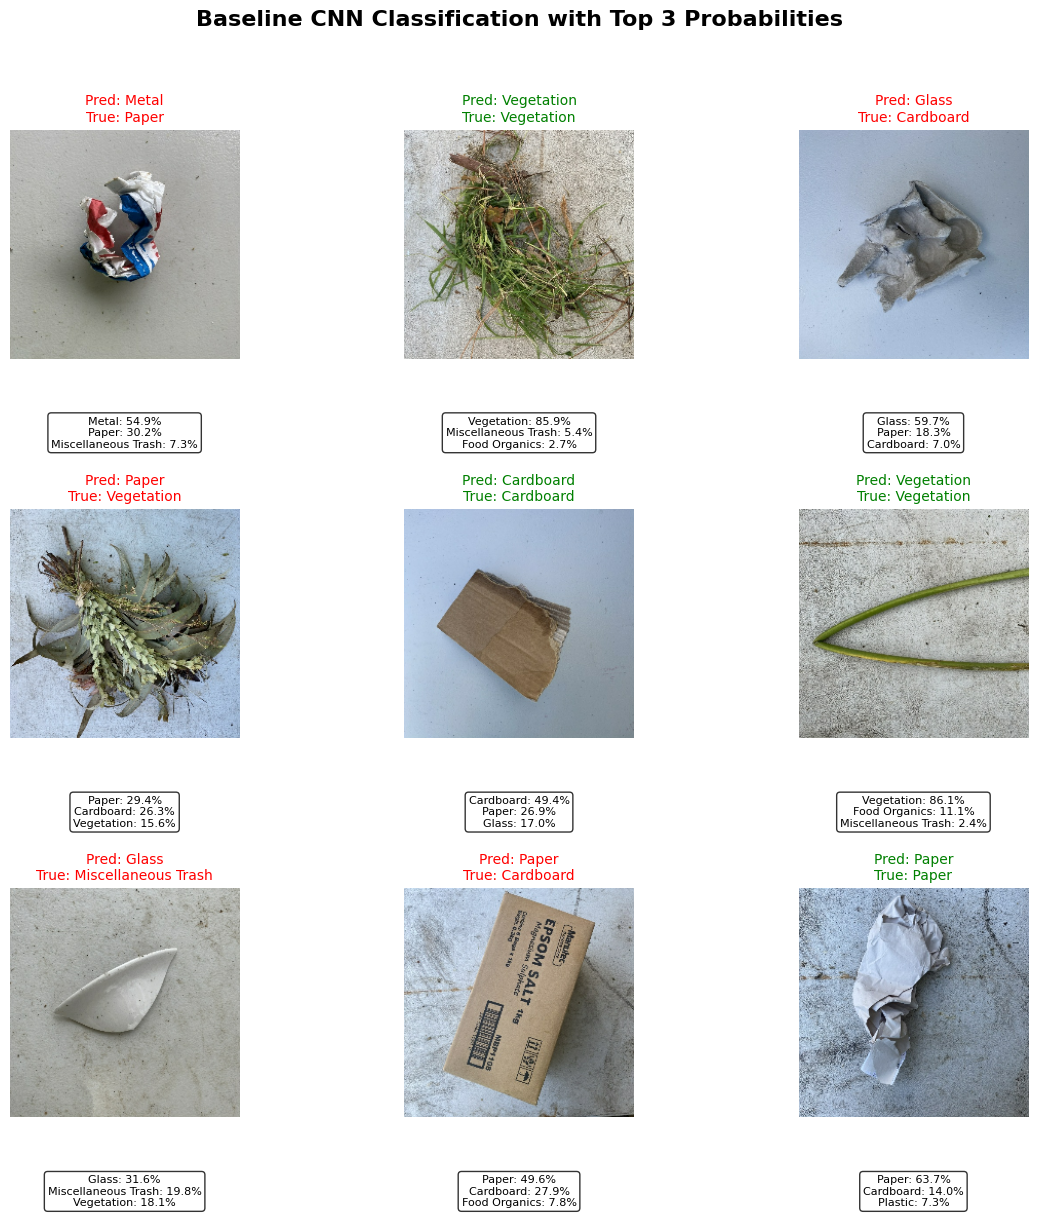

In [ ]:
classify_from_dataset(model_base, test_dataset, class_names)

# Hyperparameter Tuned CNN

In [ ]:

def build_model(hp):
    inputs = Input(shape=(224, 224, 3))

    l2_value = hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')

    x = layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(
        filters=hp.Int('filters_3', min_value=128, max_value=512, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)


    x = layers.Dense(
        hp.Int("units", min_value=64, max_value=512, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_value)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout1', min_value=0.4, max_value=0.8, step=0.1))(x)



    outputs = layers.Dense(8, activation='softmax')(x)


    model = Model(inputs=inputs, outputs=outputs)


    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
        ),
        loss= CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

In [ ]:
 rm -rf my_tuning/cnn_baseline


In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='my_tuning',
    project_name='cnn_baseline'
)

tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stop])


Trial 5 Complete [00h 09m 09s]
val_accuracy: 0.2601102963089943

Best val_accuracy So Far: 0.5527167320251465
Total elapsed time: 01h 04m 24s


In [113]:
K.clear_session()

In [114]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [115]:
history_hyper = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[lr_scheduler, reduce_lr]
)


Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 49s 446ms/step - accuracy: 0.2043 - loss: 3.2037 - val_accuracy: 0.1121 - val_loss: 2.4223 - learning_rate: 1.0000e-04
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 461ms/step - accuracy: 0.3072 - loss: 2.6400 - val_accuracy: 0.1544 - val_loss: 2.5674 - learning_rate: 1.0000e-04
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 44s 465ms/step - accuracy: 0.3402 - loss: 2.5107 - val_accuracy: 0.1232 - val_loss: 2.7903 - learning_rate: 1.0000e-04
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.3614 - loss: 2.3486
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 461ms/step - accuracy: 0.3613 - loss: 2.3490 - val_accuracy: 0.1452 - val_loss: 2.9494 - learning_rate: 1.0000e-04
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 44s 463ms/step - accuracy: 0.4097 - loss: 2.2369 - val_accuracy: 0.1544 - val_loss: 3.2418 - learning_rate: 5.0000e-05
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 460ms/step - accuracy:

In [116]:
best_model.save("/content/drive/MyDrive/my_best_model.keras")

In [117]:
y_true_hyper = []
y_pred_probs_hyper = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true_hyper.extend(labels.numpy())
    y_pred_probs_hyper.extend(preds)

y_pred_probs_hyper = np.array(y_pred_probs_hyper)
y_true_hyper = np.array(y_true_hyper)


y_pred_hyper = np.argmax(y_pred_probs_hyper, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [118]:

if y_pred_hyper.ndim > 1:
    y_pred_hyper = np.argmax(y_pred_hyper, axis=1)


if y_true_hyper.ndim > 1:
    y_true_hyper = np.argmax(y_true_hyper, axis=1)


print(classification_report(y_true_hyper, y_pred_hyper))

              precision    recall  f1-score   support

           0       0.65      0.68      0.67        73
           1       0.22      0.17      0.19        65
           2       0.74      0.38      0.51        60
           3       0.91      0.47      0.62        66
           4       0.31      0.28      0.30        61
           5       0.39      0.61      0.48        64
           6       0.33      0.25      0.29        87
           7       0.50      0.97      0.66        68

    accuracy                           0.48       544
   macro avg       0.51      0.48      0.46       544
weighted avg       0.50      0.48      0.46       544



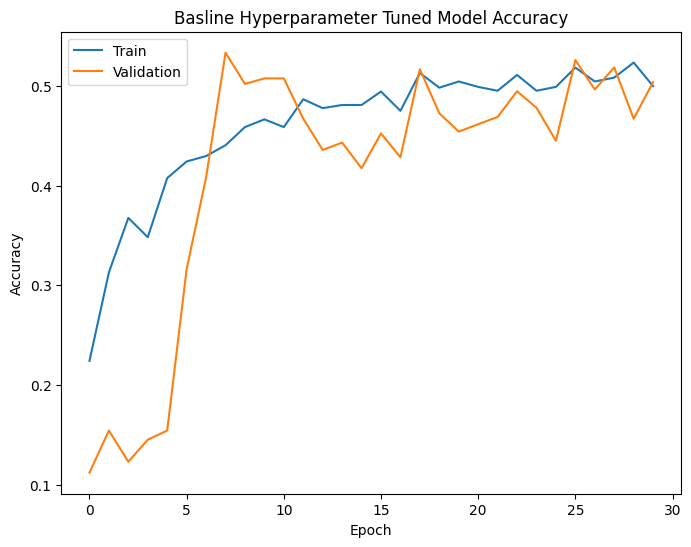

In [193]:
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history_hyper.history["accuracy"])
    plt.plot(history_hyper.history["val_accuracy"])
    plt.title("Basline Hyperparameter Tuned Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_hyper)

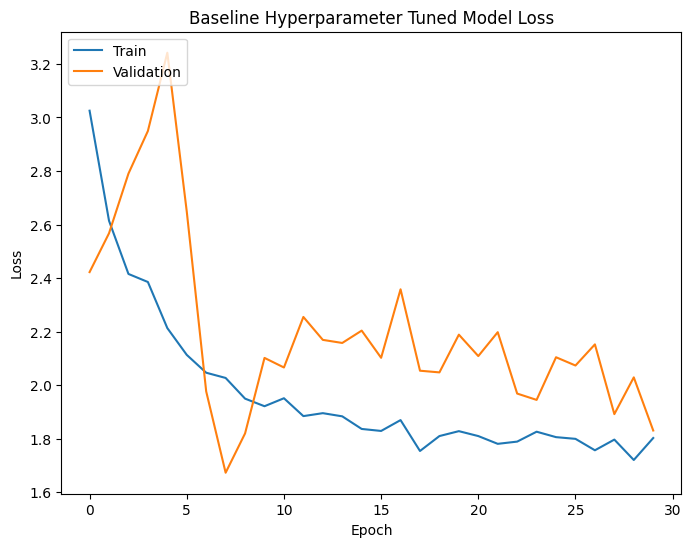

In [194]:
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history_hyper.history["loss"])
    plt.plot(history_hyper.history["val_loss"])
    plt.title("Baseline Hyperparameter Tuned Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_hyper)

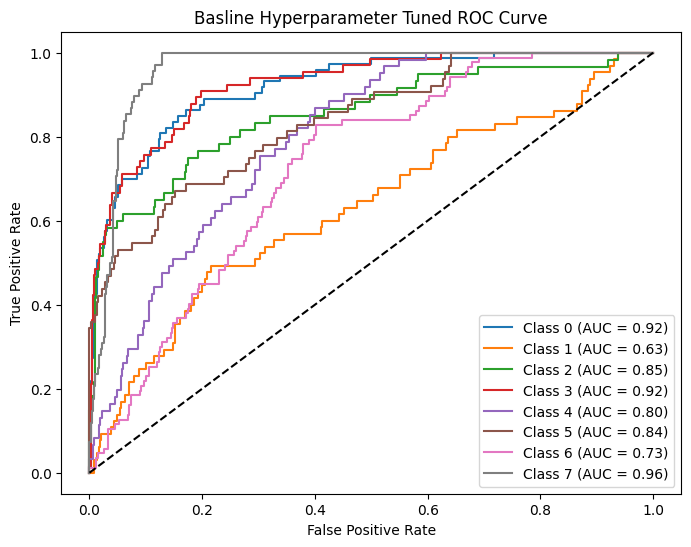

In [195]:

num_classes = 8
y_true_one_hot = to_categorical(y_true_hyper, num_classes)


plt.figure(figsize=(8, 6))

for i in range(8):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_hyper[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Basline Hyperparameter Tuned ROC Curve")
plt.legend()
plt.show()

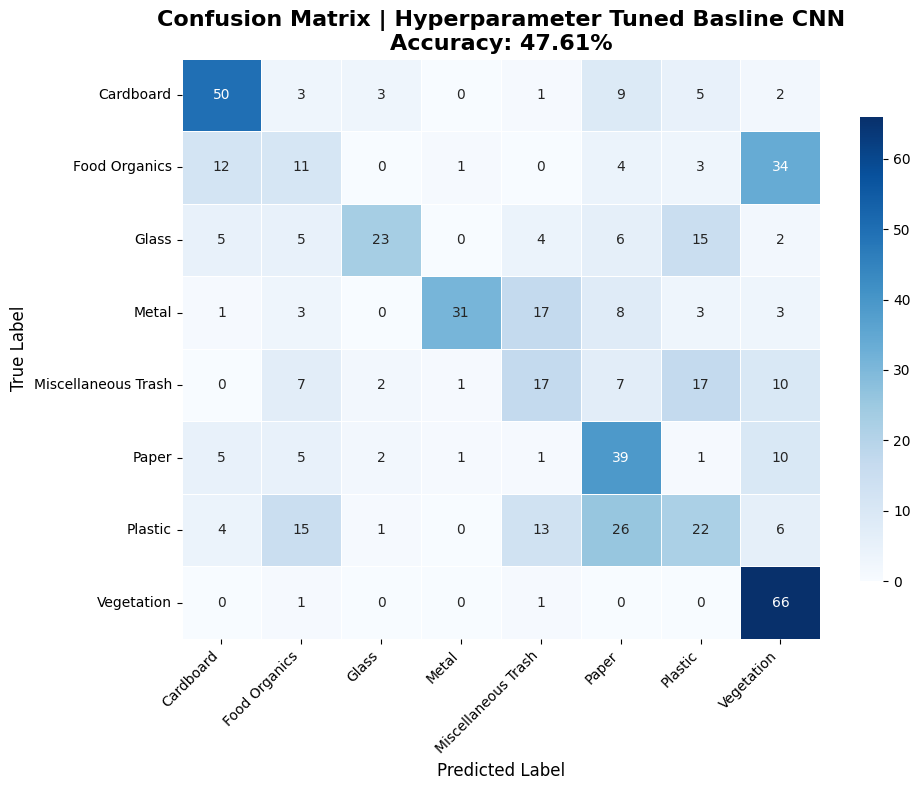

In [122]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Hyperparameter Tuned Basline CNN"):
    cm = confusion_matrix(y_true_hyper, y_pred_hyper)
    acc = accuracy_score(y_true_hyper, y_pred_hyper) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_true_hyper, y_pred_hyper, class_names, model_name="Hyperparameter Tuned Basline CNN")

In [123]:
model_hyper = load_model(
    "/content/drive/MyDrive/my_best_model.keras",
)

In [124]:
def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        predictions = model.predict(images, verbose=0)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            prob_vector = predictions[i]
            pred_label = np.argmax(prob_vector)

            ax = plt.subplot(3, 3, i + 1)


            img = image.numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            ax.imshow(img)
            ax.axis("off")


            title_color = "green" if pred_label == true_label else "red"
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                fontsize=10,
                color=title_color
            )


            top3 = np.argsort(prob_vector)[-3:][::-1]
            prob_text = "\n".join([f"{class_names[j]}: {prob_vector[j]*100:.1f}%" for j in top3])
            ax.text(0.5, -0.25, prob_text, transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle("Baseline Hyperparametered CNN Classification with Top 3 Probabilities", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()



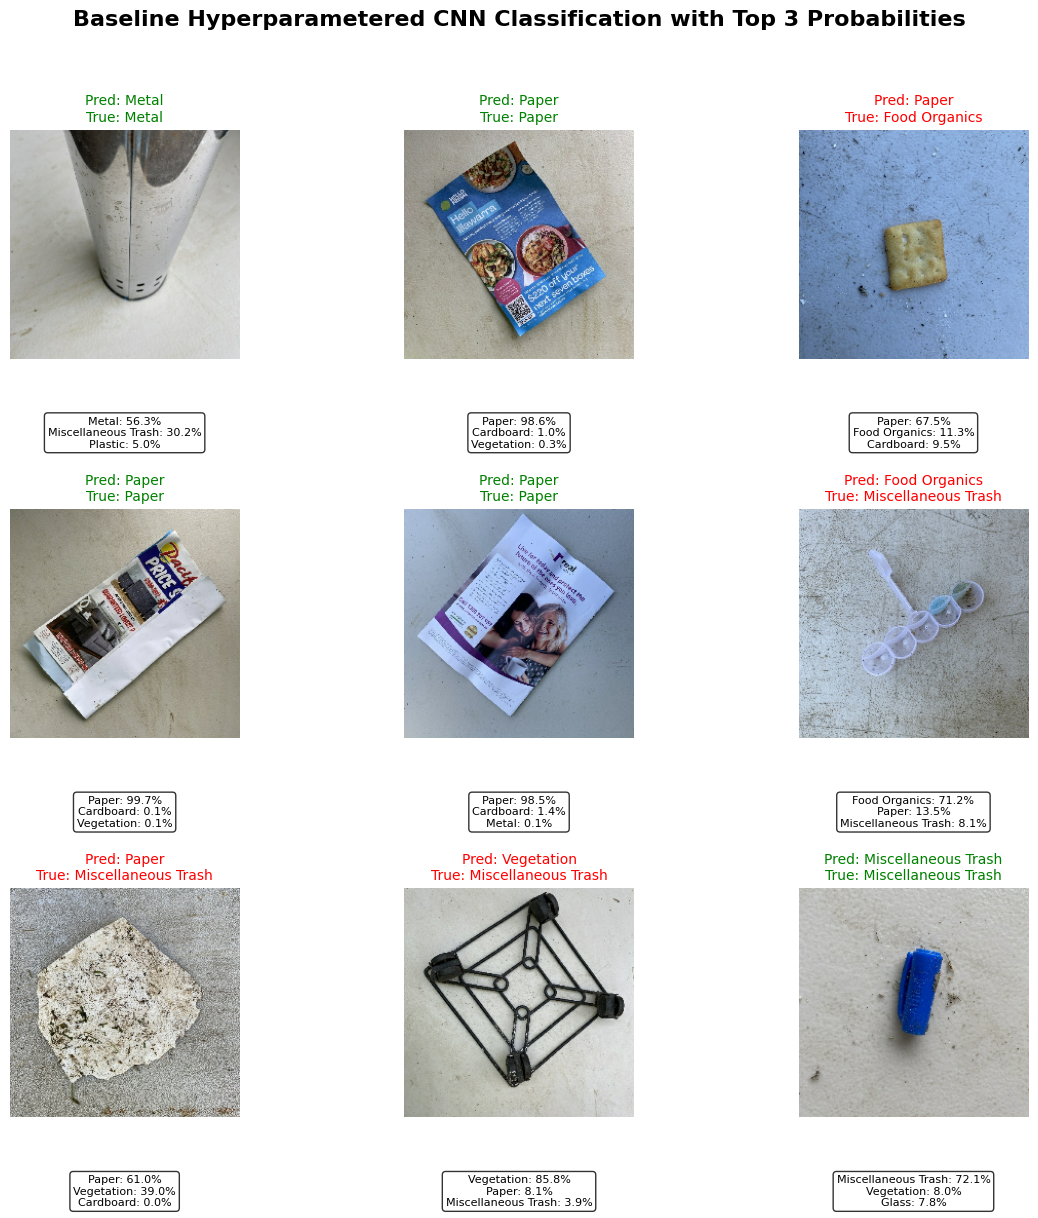

In [192]:
classify_from_dataset(model, test_dataset, class_names)

# Hyperparameter Tuned CNN With SVM

In [133]:
feature_extractor = Model(inputs=best_model.input, outputs=best_model.get_layer(index=-3).output)

In [134]:
def extract_features(dataset, feature_model):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:

        batch_features = feature_model.predict(batch_images)


        if len(batch_features.shape) == 1:
            batch_features = np.expand_dims(batch_features, axis=0)

        features.append(batch_features)


        if len(batch_labels.shape) > 1:
            batch_labels = np.argmax(batch_labels.numpy(), axis=1)
        else:
            batch_labels = batch_labels.numpy()

        labels.append(batch_labels)

    return np.vstack(features), np.concatenate(labels)

In [135]:
all_images = []
all_labels = []

for batch_images, batch_labels in dataset.unbatch().batch(1):  #
    all_images.append(batch_images[0])
    all_labels.append(batch_labels[0])

all_images = tf.stack(all_images)
all_labels = tf.stack(all_labels)

In [136]:
X, y = extract_features(tf.data.Dataset.from_tensor_slices((all_images, all_labels)).batch(32), feature_extractor)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━

In [137]:
image_array = all_images.numpy()
label_array = all_labels.numpy()


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    image_test = image_array[test_index]
    label_test = label_array[test_index]

image_array = np.array(all_images)
X_test_images = image_array[test_index]
label_array = np.array(all_labels)
y_test = label_array[test_index]



In [138]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [140]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['linear', 'rbf'],
}
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm = SVC(random_state=42, probability=True)

grid_search = GridSearchCV(svm, param_grid, cv=stratified_cv, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Cross-Validation Accuracy: 0.7656532383209246


In [141]:
svm_model = grid_search.best_estimator_

In [142]:
y_pred = svm_model.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))


Test Accuracy: 0.7884872824631861
Classification Report:
                      precision    recall  f1-score   support

          Cardboard       0.73      0.78      0.75        92
      Food Organics       0.85      0.82      0.83        82
              Glass       0.82      0.82      0.82        84
              Metal       0.81      0.85      0.83        98
Miscellaneous Trash       0.79      0.73      0.76        99
              Paper       0.70      0.66      0.68       100
            Plastic       0.76      0.79      0.78       105
         Vegetation       0.87      0.89      0.88        87

           accuracy                           0.79       747
          macro avg       0.79      0.79      0.79       747
       weighted avg       0.79      0.79      0.79       747



In [143]:
y_pred_batch = svm_model.predict(X_test_scaled[:20])
print("Predicted labels:", y_pred_batch)
print("True labels:", y_test[:20])


Predicted labels: [2 3 6 1 6 6 0 5 5 7 1 4 0 5 0 3 3 4 6 5]
True labels: [2 6 6 1 6 4 0 5 5 7 4 4 0 5 0 3 3 4 4 4]


In [144]:
print("Feature shape:", X.shape)
print("Feature variance:", np.var(X, axis=0).mean())


Feature shape: (3734, 96)
Feature variance: 93811.875


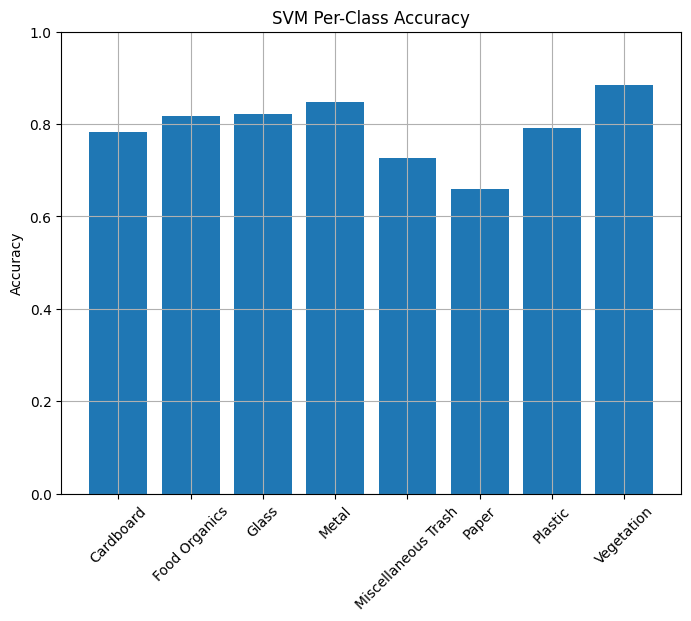

In [191]:
accs = []
for i in range(len(class_names)):
    idx = np.where(y_test == i)
    acc = accuracy_score(y_test[idx], y_pred[idx])
    accs.append(acc)

plt.figure(figsize=(8, 6))
plt.bar(class_names, accs)
plt.ylabel("Accuracy")
plt.title("SVM Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.show()


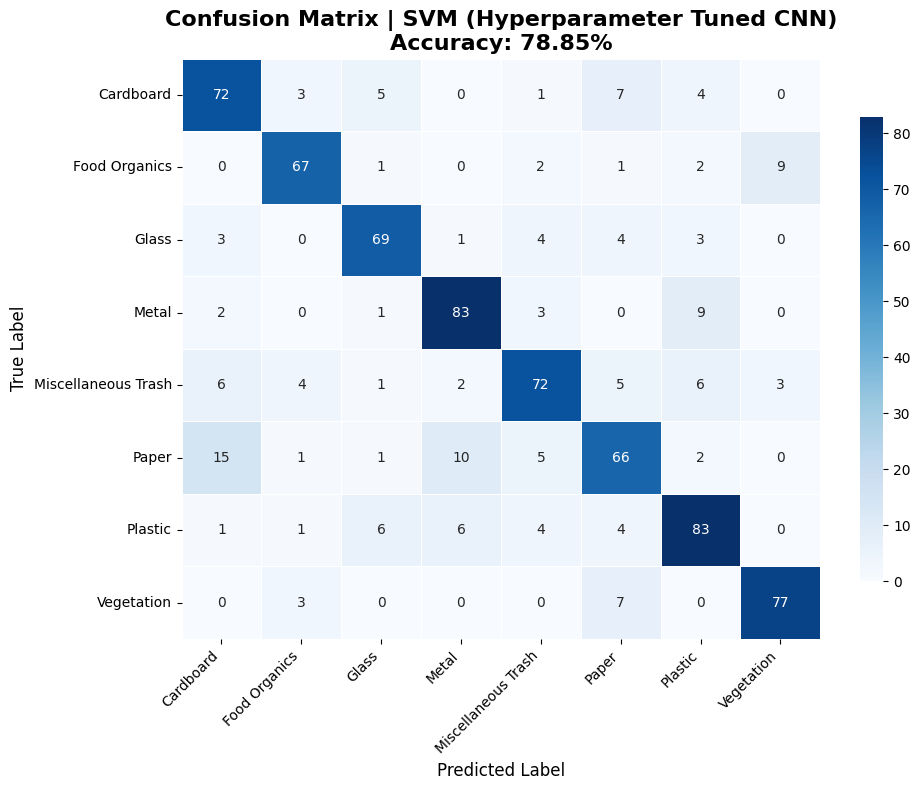

In [146]:
def plot_confusion_matrix(y_test, y_pred, class_names, model_name="SVM (Hyperparameter Tuned CNN)"):
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_test, y_pred, class_names, model_name="SVM (Hyperparameter Tuned CNN)")

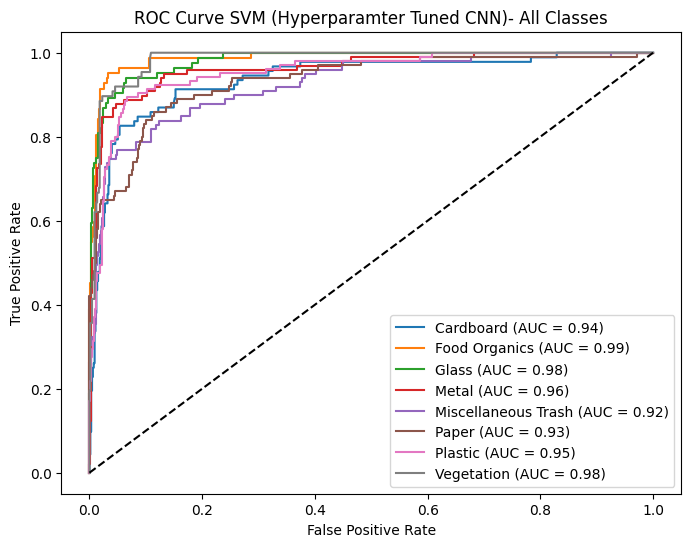

In [148]:
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]


probs = grid_search.decision_function(X_test_scaled)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM (Hyperparamter Tuned CNN)- All Classes')
plt.legend()
plt.show()


In [197]:
def visualize_predictions_with_probs(feature_extractor, svm_model, scaler,
                                     X_test_images=None, y_test=None, class_names=None,
                                     num_rows=3, num_cols=3):
    X = X_test_images.numpy() if tf.is_tensor(X_test_images) else np.array(X_test_images)
    y = y_test.numpy() if tf.is_tensor(y_test) else np.array(y_test)

    num_images = num_rows * num_cols
    total_images = X.shape[0]

    indices = random.sample(range(total_images), num_images)
    images = X[indices]
    true_labels = y[indices]

    features = feature_extractor.predict(images, verbose=0)
    features = features.reshape((features.shape[0], -1))
    features_scaled = scaler.transform(features)


    pred_labels = svm_model.predict(features_scaled)
    probs = svm_model.predict_proba(features_scaled)


    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 12))
    axes = axes.flatten()

    for i, (ax, img, true, pred, prob) in enumerate(zip(axes, images, true_labels, pred_labels, probs)):
        ax.imshow(img.astype("uint8"))
        ax.axis('off')

        true_name = class_names[true]
        pred_name = class_names[pred]
        title_color = 'green' if pred == true else 'red'

        ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10, color=title_color, pad=10)

        top3_idx = np.argsort(prob)[-3:][::-1]
        top3_probs = '\n'.join([f"{class_names[j]}: {prob[j]*100:.1f}%" for j in top3_idx])

        ax.text(0.5, -0.25, top3_probs,
                transform=ax.transAxes,
                ha='center', va='top',
                fontsize=8, family='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

        rect = patches.Rectangle((0, 0), 223, 223, linewidth=3, edgecolor=title_color,
                                 facecolor='none', transform=ax.transData)
        ax.add_patch(rect)

    plt.suptitle("SVM on Hyperparameter Tuned CNN Features: Classification with Top 3 Probabilities",
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


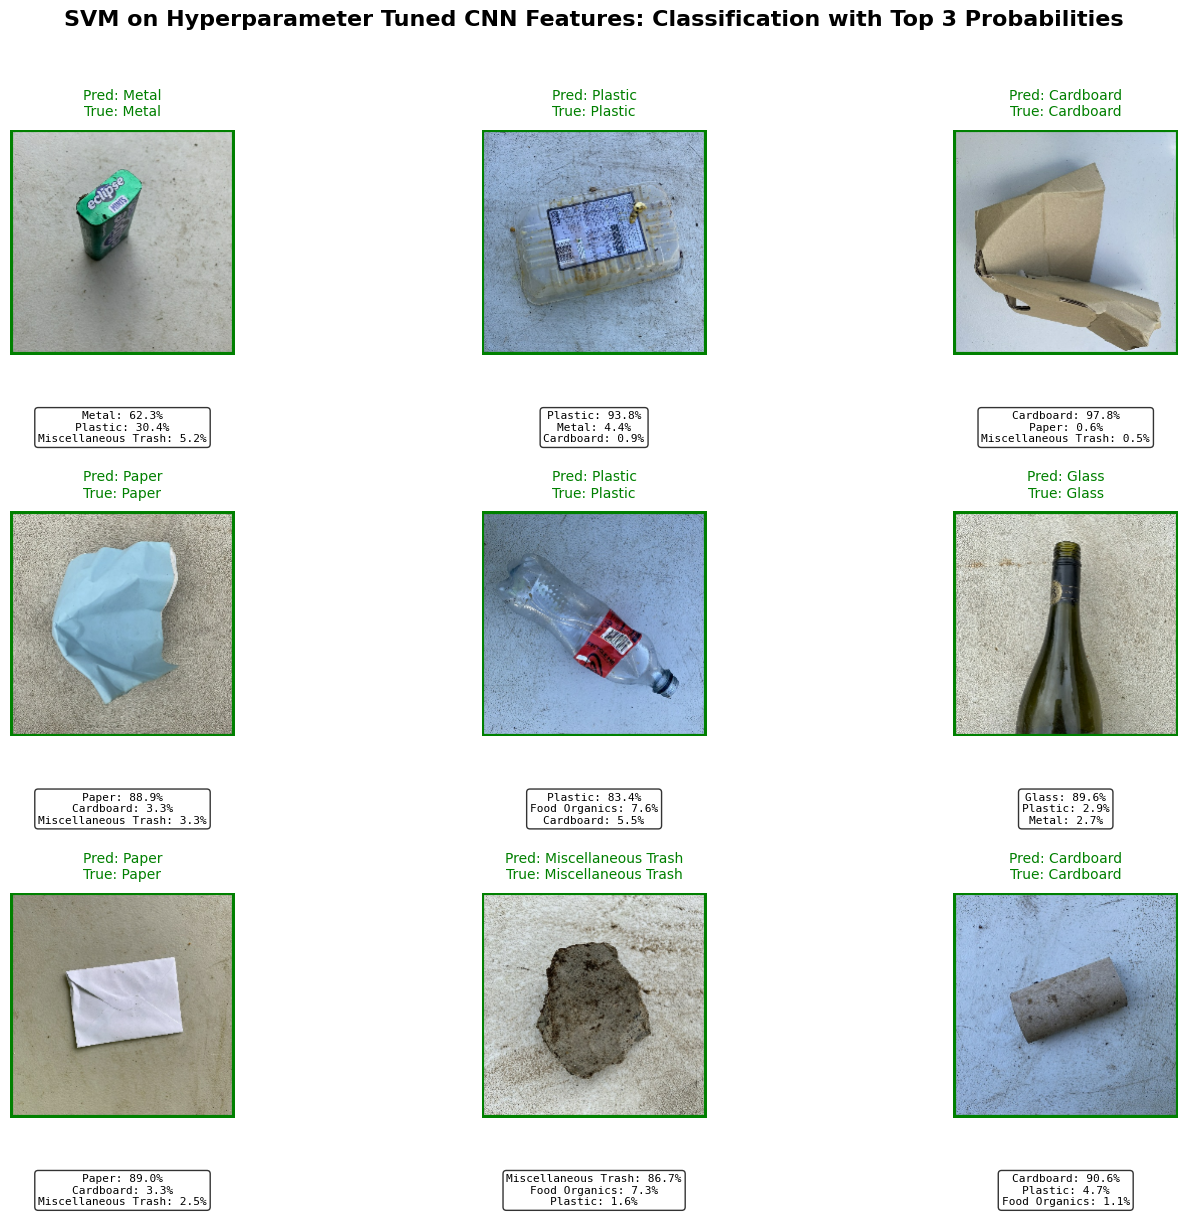

In [198]:
visualize_predictions_with_probs(
    feature_extractor,
    svm_model,
    scaler,
    X_test_images=X_test_images,
    y_test=y_test,
    class_names=class_names
)


# Basline CNN With SVM

In [151]:
model_basline = load_model(
    "/content/drive/MyDrive/my_model.keras",
)

In [152]:
feature_extractor_basline = Model(inputs=model_basline.input, outputs=model_basline.layers[-3].output)

In [153]:
def extract_features(dataset, feature_model):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:

        batch_features = feature_model.predict(batch_images)


        if len(batch_features.shape) == 1:
            batch_features = np.expand_dims(batch_features, axis=0)

        features.append(batch_features)


        if len(batch_labels.shape) > 1:
            batch_labels = np.argmax(batch_labels.numpy(), axis=1)
        else:
            batch_labels = batch_labels.numpy()

        labels.append(batch_labels)

    return np.vstack(features), np.concatenate(labels)


In [154]:
all_images = []
all_labels = []

for batch_images, batch_labels in dataset.unbatch().batch(1):
    all_images.append(batch_images[0])
    all_labels.append(batch_labels[0])

all_images = tf.stack(all_images)
all_labels = tf.stack(all_labels)

In [155]:
X, y = extract_features(tf.data.Dataset.from_tensor_slices((all_images, all_labels)).batch(32), feature_extractor_basline)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━

In [156]:
image_array = all_images.numpy()
label_array = all_labels.numpy()


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train_basline, X_test_basline = X[train_index], X[test_index]
    y_train_basline, y_test_basline = y[train_index], y[test_index]
    image_test = image_array[test_index]
    label_test = label_array[test_index]

image_array = np.array(all_images)
X_test_images = image_array[test_index]
label_array = np.array(all_labels)
y_test_basline = label_array[test_index]



In [157]:
scaler_basline = StandardScaler()
X_train_scaled_basline = scaler_basline.fit_transform(X_train_basline)
X_test_scaled_basline = scaler_basline.transform(X_test_basline)

In [158]:
param_grid_basline = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['linear', 'rbf'],
}
stratified_cv_basline = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_basline = SVC(random_state=42, probability=True)

grid_search_basline = GridSearchCV(svm_basline, param_grid_basline, cv=stratified_cv_basline, verbose=1, n_jobs=-1)
grid_search_basline.fit(X_train_scaled_basline, y_train_basline)

print("Best Parameters Basline:", grid_search_basline.best_params_)
print("Cross-Validation Accuracy Basline:", grid_search_basline.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters Basline: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Cross-Validation Accuracy Basline: 0.7147672588135774


In [159]:
svm_model_basline = grid_search_basline.best_estimator_

In [160]:
y_pred_basline = svm_model_basline.predict(X_test_scaled_basline)

print("Test Accuracy Basline:", accuracy_score(y_test_basline, y_pred_basline))
print("Classification Report Basline:\n", classification_report(y_test_basline, y_pred_basline, target_names=class_names))


Test Accuracy Basline: 0.7108433734939759
Classification Report Basline:
                      precision    recall  f1-score   support

          Cardboard       0.69      0.66      0.67        92
      Food Organics       0.70      0.76      0.73        82
              Glass       0.69      0.77      0.73        84
              Metal       0.77      0.73      0.75        98
Miscellaneous Trash       0.57      0.54      0.55        99
              Paper       0.76      0.66      0.71       100
            Plastic       0.68      0.69      0.68       105
         Vegetation       0.84      0.92      0.88        87

           accuracy                           0.71       747
          macro avg       0.71      0.72      0.71       747
       weighted avg       0.71      0.71      0.71       747



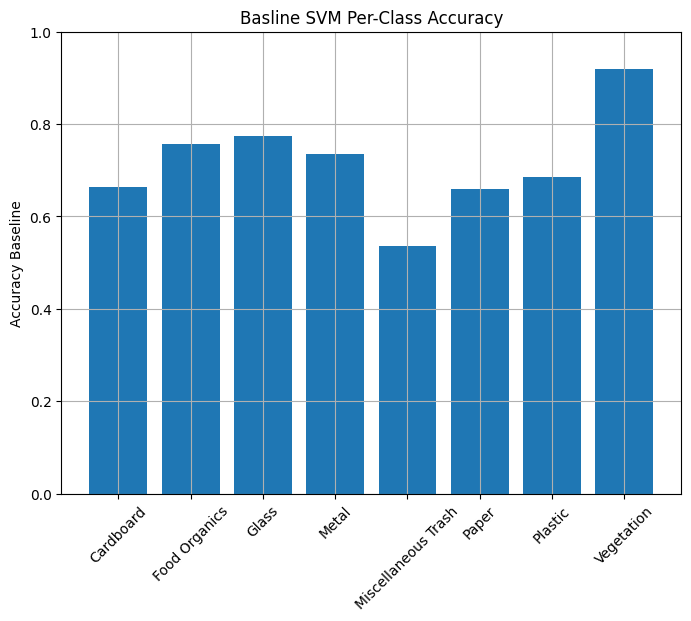

In [190]:
accs = []
for i in range(len(class_names)):
    idx = np.where(y_test_basline == i)
    acc = accuracy_score(y_test_basline[idx], y_pred_basline[idx])
    accs.append(acc)

plt.figure(figsize=(8, 6))
plt.bar(class_names, accs)
plt.ylabel("Accuracy Baseline")
plt.title("Basline SVM Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.show()


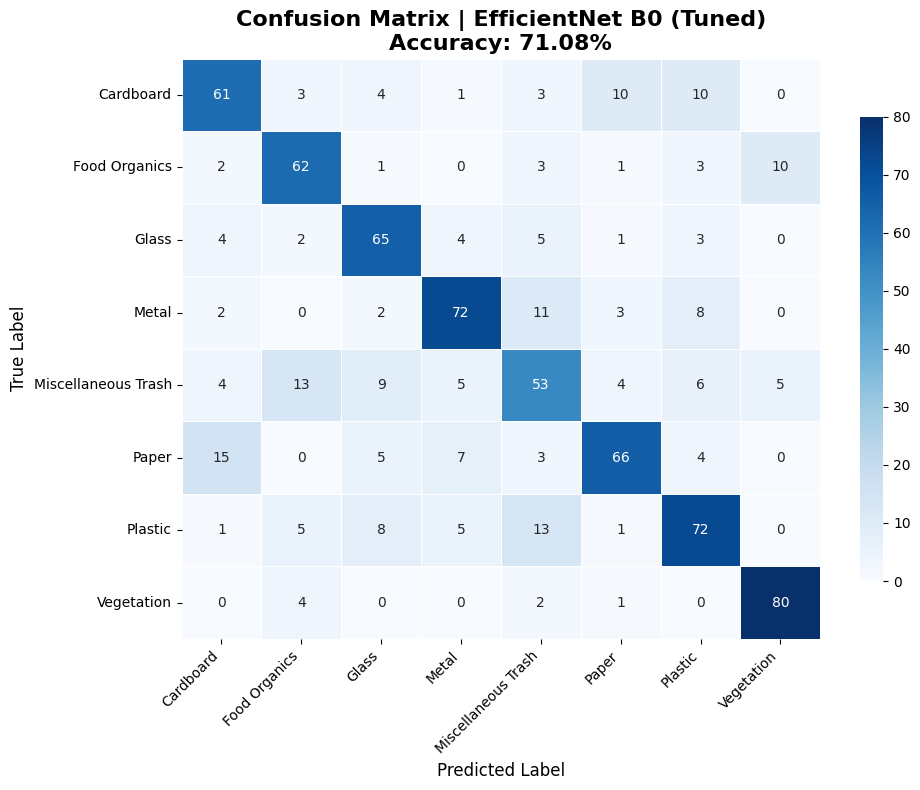

In [163]:

def plot_confusion_matrix(y_true, y_pred, class_names, model_name="EfficientNet B0"):
    cm = confusion_matrix(y_test_basline, y_pred_basline)
    acc = accuracy_score(y_test_basline, y_pred_basline) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_test_basline, y_pred_basline, class_names, model_name="EfficientNet B0 (Tuned)")

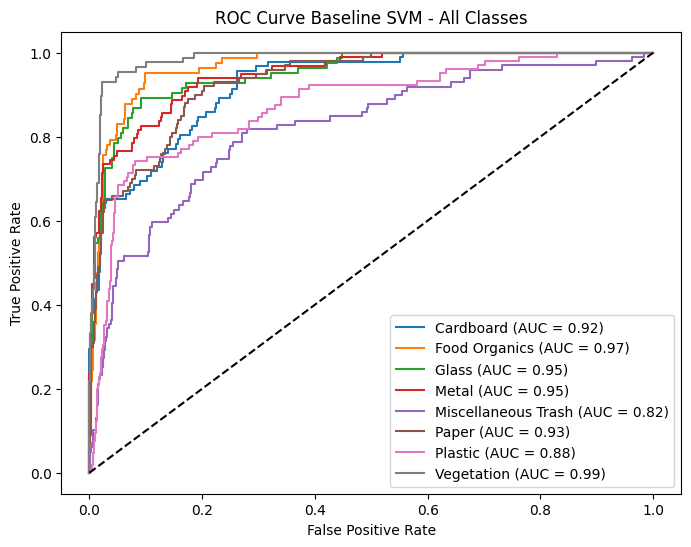

In [164]:
y_test_bin = label_binarize(y_test_basline , classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]


probs = grid_search_basline.decision_function(X_test_scaled_basline)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Baseline SVM - All Classes')
plt.legend()
plt.show()


In [188]:
def visualize_predictions_with_probs(feature_extractor, svm_model, scaler,
                                     X_test_images=None, y_test=None, class_names=None,
                                     num_rows=3, num_cols=3):

    X = X_test_images.numpy() if tf.is_tensor(X_test_images) else np.array(X_test_images)
    y = y_test_basline.numpy() if tf.is_tensor(y_test_basline) else np.array(y_test_basline)


    num_images = num_rows * num_cols
    idxs = np.random.choice(len(X), size=num_images, replace=False)
    images = X[idxs]
    true_labels = y[idxs]



    features = feature_extractor_basline.predict(images, verbose=0)
    features = features.reshape((features.shape[0], -1))


    features_scaled = scaler_basline.transform(features)


    pred_labels = svm_model_basline.predict(features_scaled)
    probs = svm_model_basline.predict_proba(features_scaled)


    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 12))
    axes = axes.flatten()

    for i, (ax, img, true, pred, prob) in enumerate(zip(axes, images, true_labels, pred_labels, probs)):
        ax.imshow(img.astype("uint8"))
        ax.axis('off')

        true_name = class_names[true]
        pred_name = class_names[pred]
        title_color = 'green' if pred == true else 'red'

        ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10, color=title_color, pad=10)


        top3_idx = np.argsort(prob)[-3:][::-1]
        top3_probs = '\n'.join([f"{class_names[j]}: {prob[j]*100:.1f}%" for j in top3_idx])

        ax.text(0.5, -0.25, top3_probs,
                transform=ax.transAxes,
                ha='center', va='top',
                fontsize=8, family='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))


        rect = patches.Rectangle((0, 0), 223, 223, linewidth=3, edgecolor=title_color,
                                 facecolor='none', transform=ax.transData)
        ax.add_patch(rect)

    plt.suptitle(" SVM on Basline CNN Features: Classification with Top 3 Probabilities ",
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()



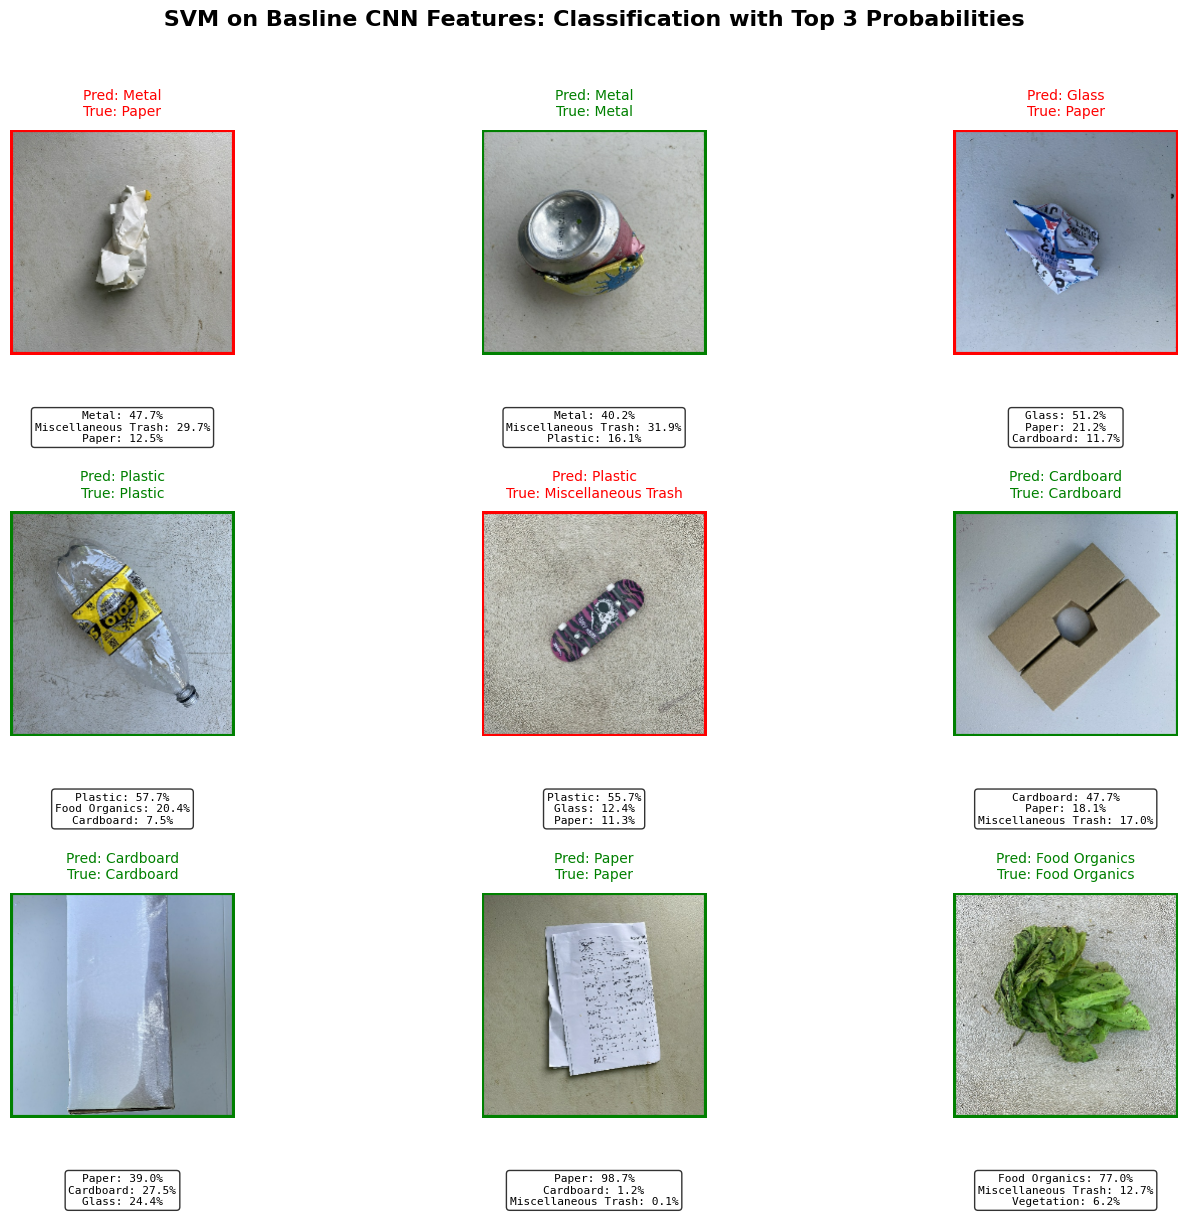

In [189]:
visualize_predictions_with_probs(
    feature_extractor_basline,
    svm_model_basline,
    scaler_basline,
    X_test_images=X_test_images,
    y_test=y_test_basline,
    class_names=class_names
)
